# Домашнє завдання: Прогнозування кредитного ризику

## Мета завдання
Застосувати знання з лекції для побудови моделі логістичної регресії, що прогнозує ймовірність дефолту за кредитом, іншими словами, що людина не поверне кредит. Ви пройдете весь цикл: від дослідницького аналізу до оцінки якості класифікаційної моделі.

## Опис датасету
**Credit Risk Dataset** містить інформацію про 32,000+ позичальників з такими параметрами:
- **person_age**: Вік позичальника
- **person_income**: Річний дохід
- **person_home_ownership**: Тип володіння житлом
- **person_emp_length**: Стаж роботи (в роках)
- **loan_intent**: Мета кредиту
- **loan_grade**: Кредитний рейтинг (A - кращий, F - гірший)
- **loan_amnt**: Сума кредиту
- **loan_int_rate**: Процентна ставка
- **loan_status**: Статус кредиту (0 = сплачено, 1 = дефолт) - **цільова змінна**
- **loan_percent_income**: Відношення кредиту до доходу
- **cb_person_default_on_file**: Історія дефолтів (Y/N)
- **cb_person_cred_hist_length**: Довжина кредитної історії

---

## Завдання 1: Завантаження та перший огляд даних (1 бал)

**Що потрібно зробити:**
1. Завантажте дані з файлу `credit_risk_dataset.csv`
2. Виведіть розмір датасету
3. Покажіть перші 5 рядків
4. Виведіть загальну інформацію про дані (кількість записів, типи колонок)
5. Перевірте розподіл цільової змінної (відсотк даних для кожного класу)

Дайте висновок, це задача збалансованої чи незбалансованої класифікації.


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt


from plotly.subplots import make_subplots


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = 'drive/MyDrive/Data_analitic/Python/credit_risk_dataset.csv'
credit_risk = pd.read_csv(data_path)

In [4]:
credit_risk.shape

(32581, 12)

In [5]:
credit_risk.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
credit_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [7]:
missing = credit_risk.isnull().sum()
missing[missing > 0]

,0
person_emp_length,895
loan_int_rate,3116


In [8]:
cloan_status_dist = credit_risk['loan_status'].value_counts()
cloan_status_percent = credit_risk['loan_status'].value_counts(normalize=True) * 100

In [9]:
cloan_status_percent

,proportion
loan_status,
0,78.183604
1,21.816396


In [10]:
cloan_status_percent = credit_risk['loan_status'].value_counts(normalize=True).mul(100).round(2)
cloan_status_percent

,proportion
loan_status,
0,78.18
1,21.82


###Це незбалансована задача. оскільки розподіл 78 на 22


---

## Завдання 2: Дослідницький аналіз даних (EDA) (4 бали)

**Що потрібно зробити:**
1. Обчисліть відсоток пропущених значень в колонках. За наявності пропущених значень - заповніть їх медіаною для числових колонок і найбільш частим значеннмя для категоріальних.
2. Проаналізуйте розподіл числових змінних.
3. Знайдіть та обробіть викиди в колонці person_income з допомогою [Interquartile range](https://uk.wikipedia.org/wiki/%D0%9C%D1%96%D0%B6%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D0%BB%D1%8C%D0%BD%D0%B8%D0%B9_%D1%80%D0%BE%D0%B7%D0%BC%D0%B0%D1%85).
4. Проаналізуйте категоріальні змінні відносно цільової та частоту зустрічання різних значень в них.
5. Візуалізуйте взаємозв'язок ознак з цільовою змінною.


In [11]:
missing_percent = credit_risk.isnull().mean() * 100
missing_percent = missing_percent.round(2)
print(missing_percent)


person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
person_emp_length             2.75
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_int_rate                 9.56
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64


In [12]:
missing_percent_ = (credit_risk.isnull().sum() / len(credit_risk)) * 100
missing_percent_ = missing_percent_.round(2)
print(missing_percent_)

person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
person_emp_length             2.75
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_int_rate                 9.56
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64


In [13]:
credit_risk[['person_emp_length', 'loan_int_rate']] = credit_risk[['person_emp_length', 'loan_int_rate']].fillna(
    credit_risk[['person_emp_length', 'loan_int_rate']].median())

In [14]:
cols = ['person_emp_length', 'loan_int_rate']
credit_risk[cols] = credit_risk[cols].fillna(credit_risk[cols].median())

In [15]:
missing_percent_ = (credit_risk.isnull().sum() / len(credit_risk)) * 100
missing_percent_ = missing_percent_.round(2)
print(missing_percent_)

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_status                   0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
dtype: float64


In [16]:
credit_risk.select_dtypes("number").describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.767994,9589.371106,11.009620,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.087372,6322.086646,3.081611,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [17]:
Q1 = credit_risk['person_income'].quantile(0.25)
Q3 = credit_risk['person_income'].quantile(0.75)
IQR = Q3 - Q1

# Межі для "стандартних" значень (без викидів)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = credit_risk[
    (credit_risk['person_income'] < lower_bound) |
    (credit_risk['person_income'] > upper_bound)]
print(f'Кількість викидів: {len(outliers)}')


Кількість викидів: 1484


In [18]:
outlier_ratio = 1484 / len(credit_risk) * 100
print(f'Частка викидів: {outlier_ratio:.2f}%')

Частка викидів: 4.55%


In [19]:
median_income = credit_risk['person_income'].median()

credit_risk['person_income'] = credit_risk['person_income'].apply(
    lambda x: median_income if x < lower_bound or x > upper_bound else x)

In [20]:
cat_columns = credit_risk.select_dtypes(include=['object', 'category']).columns
print('Категоріальні змінні:')
print(cat_columns.tolist())

Категоріальні змінні:
['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [21]:
for col in cat_columns:
    print(f"\n {col} — частоти:")
    print(credit_risk[col].value_counts(normalize=True).round(3) * 100)


 person_home_ownership — частоти:
person_home_ownership
RENT        50.5
MORTGAGE    41.3
OWN          7.9
OTHER        0.3
Name: proportion, dtype: float64

 loan_intent — частоти:
loan_intent
EDUCATION            19.8
MEDICAL              18.6
VENTURE              17.6
PERSONAL             16.9
DEBTCONSOLIDATION    16.0
HOMEIMPROVEMENT      11.1
Name: proportion, dtype: float64

 loan_grade — частоти:
loan_grade
A    33.1
B    32.1
C    19.8
D    11.1
E     3.0
F     0.7
G     0.2
Name: proportion, dtype: float64

 cb_person_default_on_file — частоти:
cb_person_default_on_file
N    82.4
Y    17.6
Name: proportion, dtype: float64


In [22]:
for col in cat_columns:
    print(f"\nЗв'язок {col} з loan_status:")
    ct = pd.crosstab(credit_risk[col], credit_risk['loan_status'], normalize='index')
    print(ct.round(3))


Зв'язок person_home_ownership з loan_status:
loan_status                0      1
person_home_ownership              
MORTGAGE               0.874  0.126
OTHER                  0.692  0.308
OWN                    0.925  0.075
RENT                   0.684  0.316

Зв'язок loan_intent з loan_status:
loan_status            0      1
loan_intent                    
DEBTCONSOLIDATION  0.714  0.286
EDUCATION          0.828  0.172
HOMEIMPROVEMENT    0.739  0.261
MEDICAL            0.733  0.267
PERSONAL           0.801  0.199
VENTURE            0.852  0.148

Зв'язок loan_grade з loan_status:
loan_status      0      1
loan_grade               
A            0.900  0.100
B            0.837  0.163
C            0.793  0.207
D            0.410  0.590
E            0.356  0.644
F            0.295  0.705
G            0.016  0.984

Зв'язок cb_person_default_on_file з loan_status:
loan_status                    0      1
cb_person_default_on_file              
N                          0.816  0.184
Y      

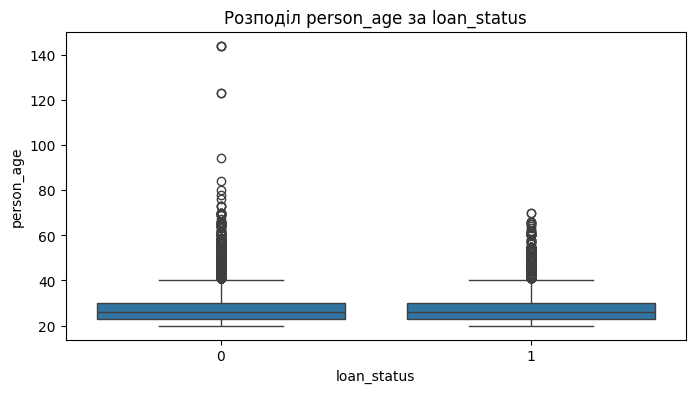

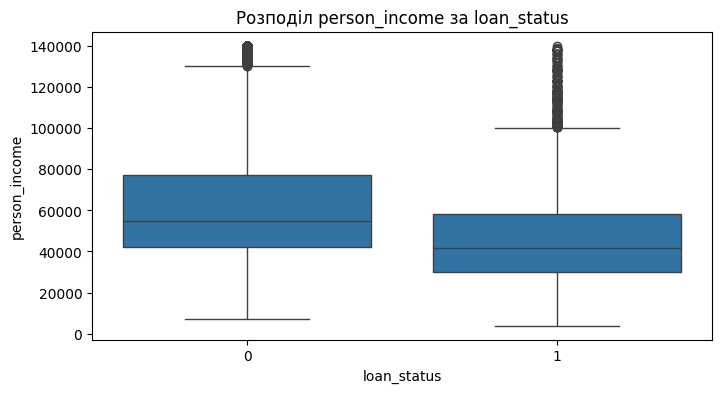

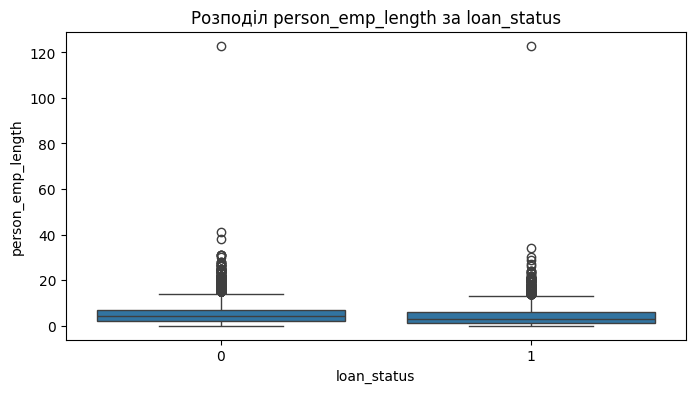

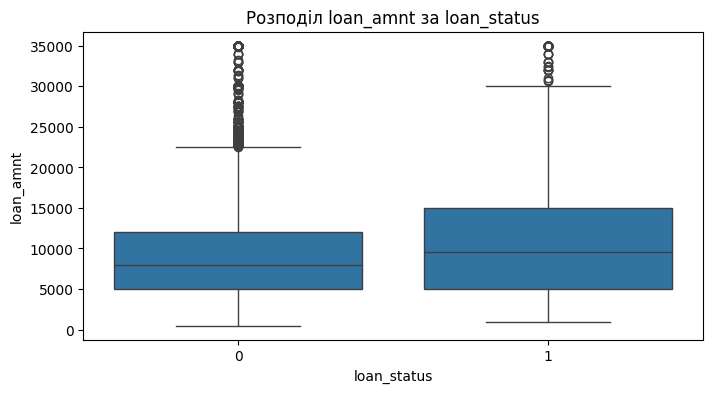

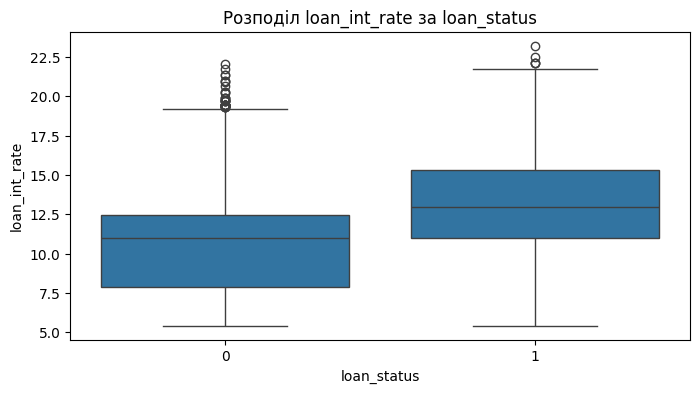

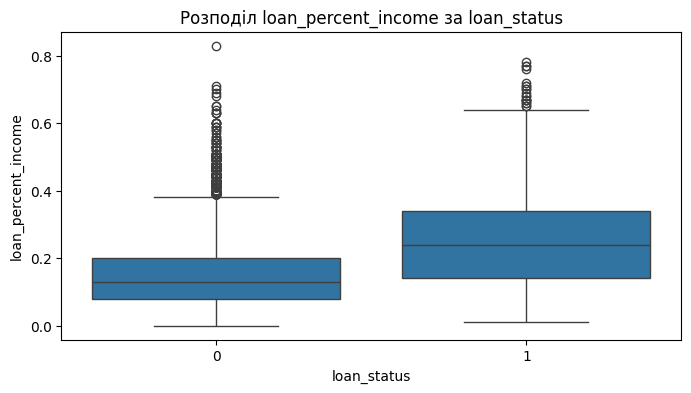

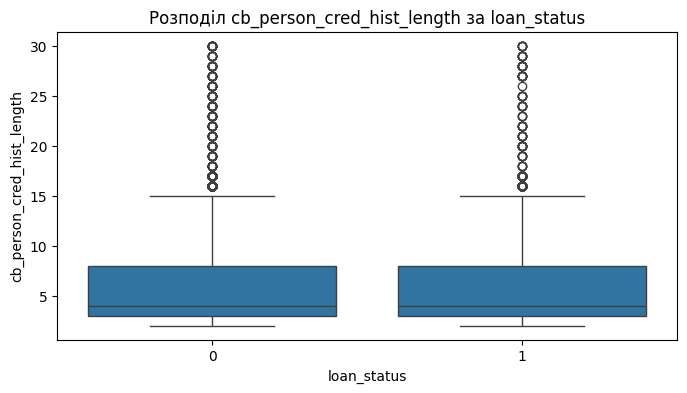

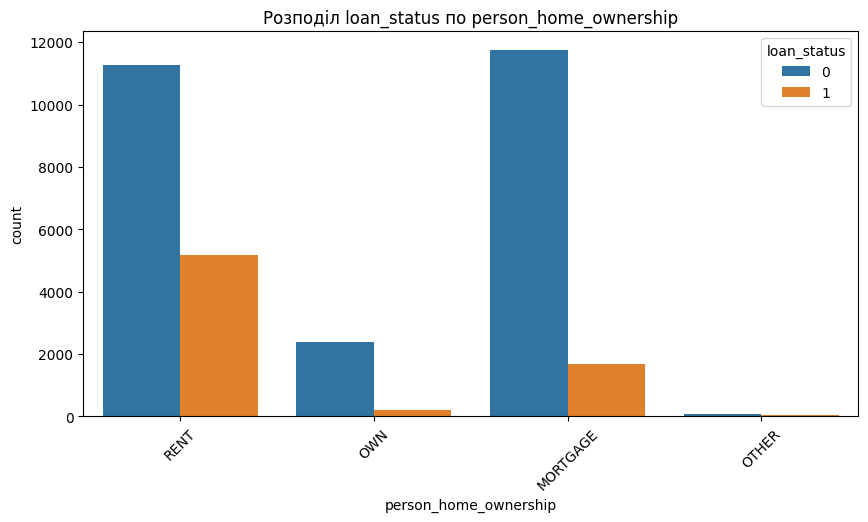

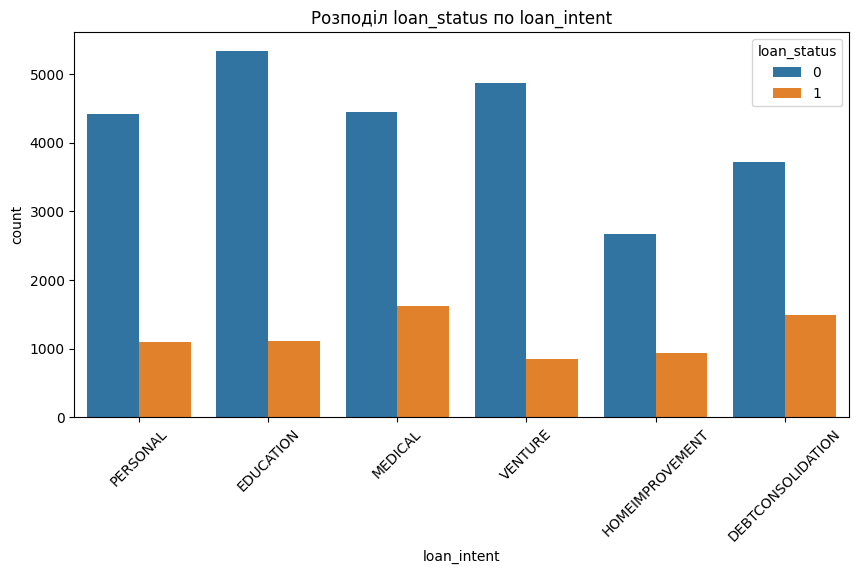

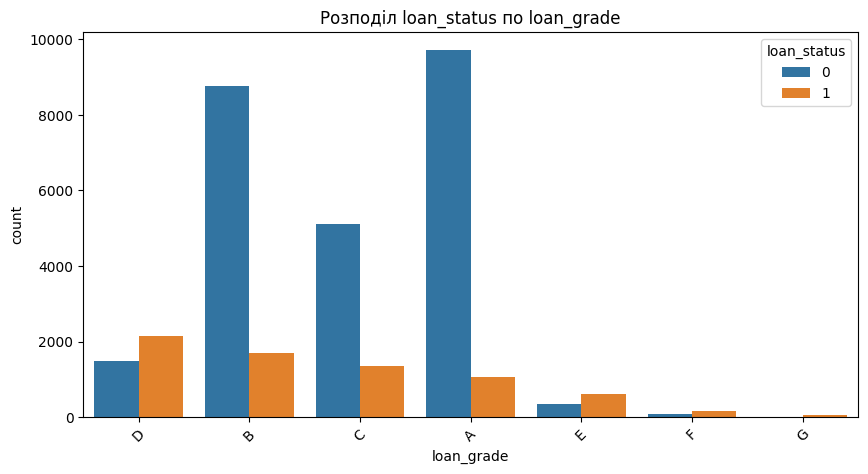

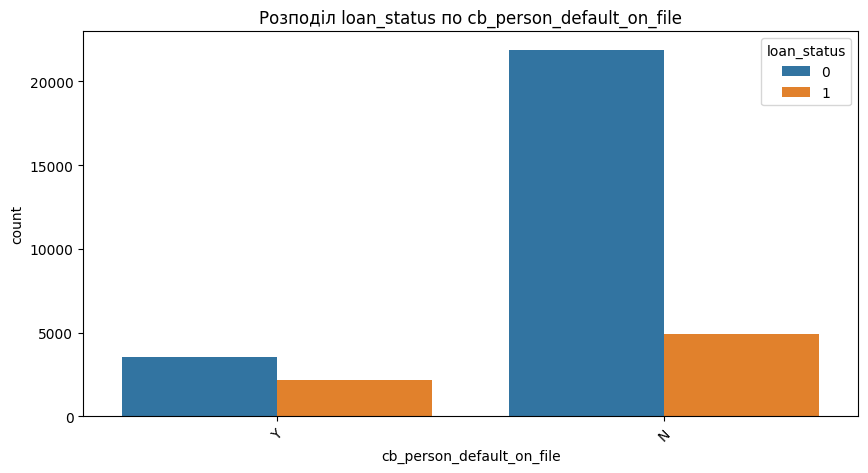

In [23]:
num_cols = credit_risk.select_dtypes(include=['int64', 'float64']).columns.drop('loan_status')
cat_cols = credit_risk.select_dtypes(include=['object', 'category']).columns

# 1. Візуалізація числових колонок
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='loan_status', y=col, data=credit_risk)
    plt.title(f'Розподіл {col} за loan_status')
    plt.show()

# 2. Візуалізація категоріальних колонок
for col in cat_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=credit_risk, x=col, hue='loan_status')
    plt.title(f'Розподіл loan_status по {col}')
    plt.xticks(rotation=45)
    plt.show()



---

## Завдання 3: Аналіз кореляцій та Feature Engineering (3 бали)

**Що потрібно зробити:**
1. Побудуйте матрицю кореляцій для числових змінних.
2. Закодуйте категоріальні змінні.
3. Виберіть фінальний набір ознак, можна лишити всі, якщо ви вважаєте, що це - доцільно.



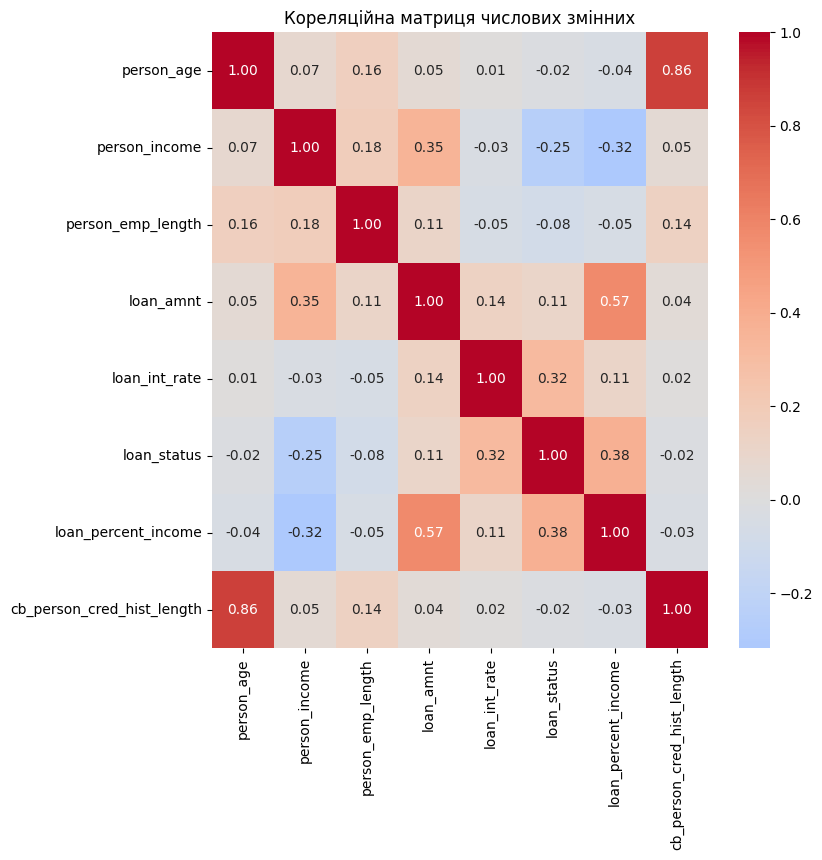

In [24]:
# Вибираємо числові колонки
num_cols = credit_risk.select_dtypes(include=['int64', 'float64']).columns

# Обчислюємо кореляційну матрицю
corr_matrix = credit_risk[num_cols].corr()

# Візуалізуємо матрицю кореляцій
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Кореляційна матриця числових змінних')
plt.show()


In [25]:
# One-hot encoding
credit_risk_encoded = pd.get_dummies(credit_risk, columns=cat_columns, drop_first=True)

In [26]:
# Обчислюємо кореляції з цільовою змінною
corr_matrix = credit_risk.corr(numeric_only=True)
top_corr = corr_matrix['loan_status'].abs().sort_values(ascending=False)

# Відкидаємо саму Rent
top_corr = top_corr.drop('loan_status')

# Вибираємо ознаки з кореляцією > 0.1
top_corr_features = top_corr[top_corr > 0.1].index.tolist()

In [27]:
top_corr_features

['loan_percent_income', 'loan_int_rate', 'person_income', 'loan_amnt']

In [28]:
exclude_cols = ['loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_income', 'loan_status'] + list(cat_columns)
feature_cols = [col for col in credit_risk_encoded.columns if col not in exclude_cols]

X = credit_risk_encoded[feature_cols]
y = credit_risk_encoded['loan_status']

print(f'Кількість ознак: {X.shape[1]}')
print(f'Розмір вибірки: {X.shape[0]}')

Кількість ознак: 18
Розмір вибірки: 32581



---

## Завдання 4: Підготовка даних та навчання моделі (3 бали)

**Що потрібно зробити:**
1. Розділіть дані на X та y
2. Поділіть на навчальну та тестову вибірки
3. Застосуйте масштабування
4. Навчіть модель логістичної регресії
5. Зробіть прогнози на тренувальній та тестовій вибірках.



In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Важливо! Зберігаємо пропорції класів
)

print(f'Train: {X_train.shape[0]} клієнтів')
print(f'Test: {X_test.shape[0]} клієнтів')
print(f'Відтік в train: {y_train.mean():.1%}')
print(f'Відтік в test: {y_test.mean():.1%}')

Train: 26064 клієнтів
Test: 6517 клієнтів
Відтік в train: 21.8%
Відтік в test: 21.8%


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
from sklearn.linear_model import LogisticRegression

# Створюємо та навчаємо модель
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [32]:
# Прогнозуємо класи
y_pred = model.predict(X_test_scaled)

# Прогнозуємо ймовірності
y_pred_proba = model.predict_proba(X_test_scaled)


---

## Завдання 5: Оцінка якості моделі (4 бали)

**Що потрібно зробити:**
1. Побудуйте confusion matrix.
2. Обчисліть основні метрики (accuracy, precision, recall, f1).
3. Побудуйте ROC-криву та обчисліть AUC
4. Проаналізуйте важливість ознак.
5. Зробіть висновки про якість моделі та які ознаки найбільше впливають на прогноз.


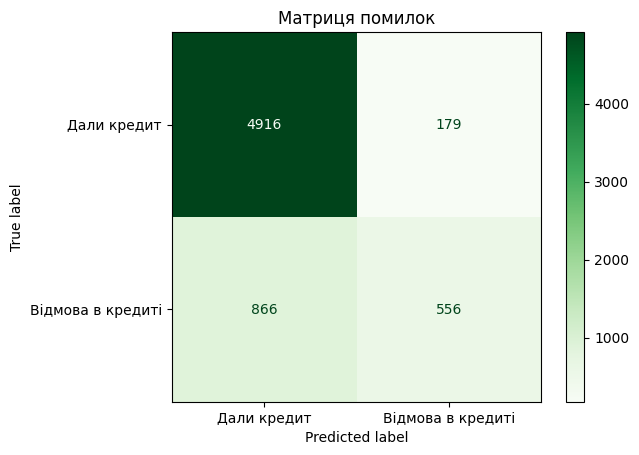

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Дали кредит', 'Відмова в кредиті'])
disp.plot(cmap='Greens')
plt.title('Матриця помилок')
plt.show()

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('МЕТРИКИ ЯКОСТІ МОДЕЛІ:')
print(f'Accuracy (Точність):    {accuracy:.3f}')
print(f'Precision (Влучність):  {precision:.3f}')
print(f'Recall (Повнота):       {recall:.3f}')
print(f'F1-score:               {f1:.3f}')

МЕТРИКИ ЯКОСТІ МОДЕЛІ:
Accuracy (Точність):    0.840
Precision (Влучність):  0.756
Recall (Повнота):       0.391
F1-score:               0.516


In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

# Обчислюємо ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Візуалізація
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC (AUC = {auc:.3f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'),
                        name='Випадковий класифікатор'))
fig.update_layout(
    title='ROC-крива',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    height=500
)
fig.show()

###Враховуючи, що AUC= 0.787, то маємо прийнятну модель

In [37]:
# Отримуємо коефіцієнти моделі
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

feature_importance

,feature,coefficient,abs_coefficient
13,loan_grade_D,0.818616,0.818616
5,person_home_ownership_RENT,0.596680,0.596680
14,loan_grade_E,0.478342,0.478342
10,loan_intent_VENTURE,-0.342309,0.342309
15,loan_grade_F,0.280692,0.280692
6,loan_intent_EDUCATION,-0.273217,0.273217
12,loan_grade_C,0.270074,0.270074
16,loan_grade_G,0.263180,0.263180
11,loan_grade_B,0.206058,0.206058
4,person_home_ownership_OWN,-0.188056,0.188056


###Висновок
- модель має прийнятну якість (AUC = 0.787).
- найбільше на прогноз впливають: клас позики (loan_grade), тип житлового статусу (home_ownership), тип призначення позики (loan_intent)
- ці результати узгоджуються з логікою ризику: гірший клас — вища ймовірність відмови.

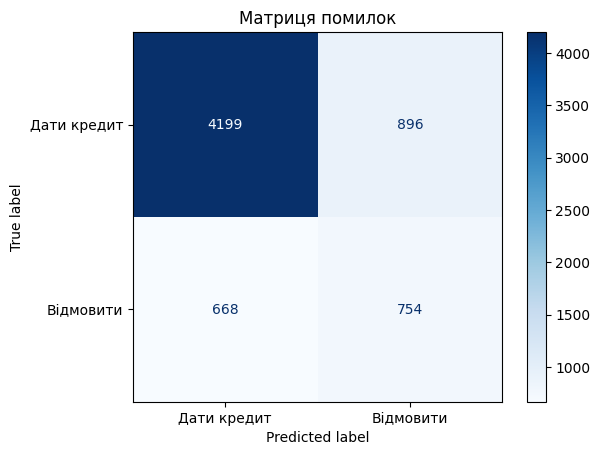

In [56]:
y_pred_opt = y_pred_proba >= 0.315

cm = confusion_matrix(y_test, y_pred_opt)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Дати кредит', 'Відмовити'])
disp.plot(cmap='Blues')
plt.title('Матриця помилок')
plt.show()


---

## Завдання 6: Оптимізація порогу та бізнес-аналіз (2 бали)

**Що потрібно зробити:**
1. Проаналізуйте метрики precision, recall, F1 при різних порогах класифікації (мінімум - 5 різних порогів). Візуалізуйте як змінюються метрики якості при зміні порогу.
2. Оберіть оптимальний поріг для бізнес-задачі - можна обрати виходячи з попереднього пункту, або додати своїх роздумів і обрати інший.



In [40]:
# Аналіз різних порогів
thresholds = np.arange(0.1, 0.91, 0.05)
metrics_by_threshold = []

for threshold in thresholds:
    y_pred_custom = (y_pred_proba[:, 1] >= threshold).astype(int)

    metrics_by_threshold.append({
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_custom),
        'recall': recall_score(y_test, y_pred_custom),
        'f1': f1_score(y_test, y_pred_custom)
    })

metrics_df = pd.DataFrame(metrics_by_threshold)

# Візуалізація
fig = px.line(
    metrics_df.melt(id_vars='threshold'),
    x='threshold',
    y='value',
    color='variable',
    title='Метрики при різних порогах рішення',
    labels={'value': 'Значення метрики', 'threshold': 'Поріг'},
)
fig.show()

####оптимальний поріг - 0.3 - 0.35
- цьому діапазоні F1-метрика найвища, тобто досягнутий хороший баланс між точністю та повнотою.


---

## Завдання 7 (Опціональне): Покращення моделі та висновки (2 бали)

**Що потрібно зробити:**

На цих же даних навчіть DecisionTreeClassifier та RandomForestClassifier. Яка з трьох моделей дає найкращий результат на тестовому наборі?

Поріг класифікації можна для порівняння якостей моделей використовувати стандартний 0.5, або той, що ви виявили, як оптимальний на попередньому кроці.


In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- 1. Decision Tree ---
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# --- 2. Random Forest ---
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# --- 3. Logistic Regression ---
log_reg_model = model

# --- 4. Прогнози ---
y_pred_logreg = log_reg_model.predict(X_test_scaled)
y_pred_tree = tree_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# --- 5. Оцінка ---
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_logreg))

print("=== Decision Tree ===")
print(classification_report(y_test, y_pred_tree))

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5095
           1       0.76      0.39      0.52      1422

    accuracy                           0.84      6517
   macro avg       0.80      0.68      0.71      6517
weighted avg       0.83      0.84      0.82      6517

=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      5095
           1       0.54      0.46      0.50      1422

    accuracy                           0.80      6517
   macro avg       0.70      0.68      0.69      6517
weighted avg       0.79      0.80      0.79      6517

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      5095
           1       0.64      0.43      0.51      1422

    accuracy                           0.82      6517
   macro avg       0.75      0.68      0.70      6517
we

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Навчаємо альтернативні моделі
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba)
    })

results_df = pd.DataFrame(results).round(3)
print(results_df)

                 Model  Accuracy  Precision  Recall     F1    AUC
0  Logistic Regression     0.840      0.756   0.391  0.516  0.787
1        Decision Tree     0.840      0.819   0.341  0.482  0.768
2        Random Forest     0.824      0.645   0.426  0.513  0.755


####Висновок:
- Logistic Regression має найкращий баланс між precision та recall (F1 = 0.516) і найвищий AUC, тому загалом вона дає найкращий результат для задачі.
- Decision Tree має найвищу точність (precision), але слабшу здатність виявляти позитивні випадки (низький recall), через що F1 нижчий.
- Random Forest краще "ловить" відтоки (вищий recall), але жертвуючи точністю і загальною якістю.